# Neural network-based model for the identification of Bladder Cancers subtypes

## Induction method

### Pretreatment of the data:
- necessary libraries imports
- dataframe definition
- dataframe sorting and cleaning

In [9]:
# Libraries imports
import os
import torch
os.environ['TORCH'] = torch.__version__
import torch.nn.functional as F
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Dataframe definition
Dataframe_Labels = pd.read_csv("../../BLCA_DATA/Workspace/labels_str.csv")          # Contains the labels of each patient (=cancer)
Dataframe_link = pd.read_csv("../../BLCA_DATA/Workspace/patient_norm.csv")          # Contains the clinic datas of each patient (will be used for link initialization)
Dataframe_node = pd.read_csv("../../BLCA_DATA/Workspace/node_embedding.csv")        # Contains the omic datas of each patient (will be used for node initialization)

# Adding a column to associate each class to a integer
Dataframe_Labels['class_int'], uniques = pd.factorize(Dataframe_Labels['class'])

# Filtering the dataframe to get rid of the two last classes (not enough datas)
Dataframe_Labels = Dataframe_Labels[~Dataframe_Labels['class_int'].isin([4, 5])]

patients_to_keep = Dataframe_Labels['Patient'].unique()
Dataframe_link = Dataframe_link[Dataframe_link['Patient'].isin(patients_to_keep)]
Dataframe_node = Dataframe_node[Dataframe_node['Patient'].isin(patients_to_keep)]

# Reset the labels to get clean Dataframes
Dataframe_Labels = Dataframe_Labels.reset_index(drop=True)
Dataframe_link = Dataframe_link.reset_index(drop=True)
Dataframe_node = Dataframe_node.reset_index(drop=True)
len(Dataframe_Labels)


378

### Graph initialization (weight, nodes and links)

Each weight is defined following this formula :
$$\mu = \text{mean of the number of patient victim of a type of cancer}$$
$$n_i = \text{number of victim of each cancer}$$
$$w_i = \text{weight of the ith class}$$

$$w_i = \frac{\frac{\mu}{n_i}}{\sum \left( \frac{\mu}{n_j} \right)}$$

In [10]:
# class dictionnary 
classes_dict = {0: 'LumP', 
                1: 'Ba/Sq', 
                2: 'LumU', 
                3: 'Stroma-rich'
}

# This function aims at giving weight to each node depending on which cancer the patient has
# It gives the classes contained in the tensor and the weights of each class in the graph
def count_classes_weights(tensor):
    array = tensor.numpy()
    classes_tab = { 0: 0, 
                    1: 0,
                    2: 0, 
                    3: 0
    }
    for i in array:
        classes_tab[i]+=1

    mean_nb_classes = 0
    for i in classes_tab:
        mean_nb_classes += i
    mean_nb_classes *= 1/len(classes_tab)
    
    # normalize the weights
    weight_sum = 0
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_sum += mean_nb_classes / classes_tab[i]
    alpha = 1 / weight_sum

    weight_dict = {}
    used_classes = []
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_dict[i] = alpha * (mean_nb_classes / classes_tab[i]) *50
            used_classes.append(classes_dict[i])

    return used_classes, weight_dict

Nodes and links initialization :

In [11]:
# Definition of the features that will be used to define each node 
node_features = Dataframe_node.drop(columns=['Patient']).values
node_features = torch.tensor(node_features, dtype=torch.float)

# This function aims at creating a Data object that will store the caracteristics of a graph
# It needs:
# - indices (which are the patient wanted in the graph)
# - similarity_threshold (which level of similarity is considered big enough to build a link between two nodes)
# - num_classes (how many classes do we want to identify, default = 4)
def get_data(indices, similarity_threshold, num_classes=4):
    x_data = node_features[indices]

    # Setting a similarity between patients - we use cosine_similarity
    patient_similarity = cosine_similarity(Dataframe_link.iloc[:, 1:])

    # Calculate the edges indexes and attention coefficients
    edge_index = []
    edge_attr = []
    # These will help to reorder the nodes 
    re_indexed_i = 0
    re_indexed_j = 0
    for i in indices:
        for j in indices:
            if i >= j :
                break
            if patient_similarity[i, j] > similarity_threshold:
                edge_index.append([re_indexed_i, re_indexed_j])
                edge_attr.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))
            re_indexed_j +=1
        re_indexed_i +=1
        re_indexed_j = 0

    # Setting the labels of each nodes
    node_labels = Dataframe_Labels["class_int"].values
    labels = torch.tensor(node_labels[indices], dtype=torch.long)

    # Setting the weight
    node_labels = torch.tensor(node_labels, dtype=torch.long)
    used_classes, weight_dict = count_classes_weights(node_labels)
    Dataframe_Labels['weight'] = [weight_dict[x] for x in Dataframe_Labels['class_int']]
    node_weights = torch.tensor(Dataframe_Labels['weight'], dtype=torch.float)

    # Setting the features, connexions (edge_index and edge _attr) and weight of each nodes
    edge_features = torch.tensor(x_data, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.int64).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    node_weights = node_weights[indices]

    # Data object definition
    data = Data(
        x=edge_features,                       # node informations 
        edge_index=edge_index,                 # node connexions (which nodes are connected)
        edge_attr=edge_attr,                   # node connexions (importance of each connexion)
        y=labels,                              # node labels
        weights=node_weights,                  # node weight
        num_classes=num_classes,               # number of classes in the graph
        num_nodes = len(edge_features),        # number of nodes
        num_features = edge_features.shape[1], # number of features
        indices = indices                      # original indices of each nodes (in the dataframe)
    )

    return data


### Graph neural network definition: GATv2

source code available at: https://github.com/tech-srl/how_attentive_are_gats

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from torch_geometric.nn import GATv2Conv
import seaborn as sn

# GATv2 initialization
class GATv2(torch.nn.Module):
    def __init__(self, hidden_channels, heads, data):
        super(GATv2, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GATv2Conv(data.num_features, hidden_channels, heads=heads, edge_dim=1)
        self.conv2 = GATv2Conv(hidden_channels * heads, data.num_classes, edge_dim=1)
        
    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x
    
# Entropy loss function
def weighted_cross_entropy_loss(output, target, weights):
    loss = F.cross_entropy(output, target, reduction='none')
    weighted_loss = loss * weights[target]
    return weighted_loss.mean()

# Train function
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = weighted_cross_entropy_loss(out[data.train_mask], data.y[data.train_mask], data.weights[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, model

# Test function
def test(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask]

### Construction of several graphs: Induction method

The induction method consists in building several "small" training graphs and training the model on each one of them. The model will be evaluated on a test graph, separated from the other ones.

In [13]:
from sklearn.model_selection import train_test_split

similarity_threshold = 0.5
test_size = 0.2
n_graphs = 5  # number of graphs used for the training and validation

# Definition of train/val and test indices
train_val_indices, test_indices = train_test_split(
    range(len(node_features)), 
    test_size=test_size, 
    random_state=1234
)

# This function aims at splitting the train/val indices into 5 groups
def split_indices(indices, n_graphs):
    np.random.shuffle(indices)
    return np.array_split(indices, n_graphs)

# Splitting the train/val indices into 5 groups
split_train_val_indices = split_indices(train_val_indices, n_graphs)

# Printing an example 
for i, indices in enumerate(split_train_val_indices):
    print(f"Subset {i+1}: {indices}, {len(indices)}")


Subset 1: [177 359 275  76   1  28 164 371 288 287 123   0 120 361 303  62 241   4
 245 318 296 238 109  27  11 186  61 337 211 364 131  25 201 344 308   6
 182 236 158 353 283 333  60  26 249 117 248  58 343  15 130 339 350  72
 118 373 136 156 224  65   8], 61
Subset 2: [148  89 226 234  48 140 135 225 304 227 233  96 363  47  12 149 235  79
  56 280 334 312 269 121 106 206 260  52  30 167 356  49 294 107 311 208
   3  31 325 174 103  95 247 372 145 365 242 349 244 213  74 122 314 218
 254 285 141 299 310 257 187], 61
Subset 3: [147 295 196 155 172 199 290 185   5 113  23  46 322 184  41 266 160  98
 132  10 126 175 354 231  35 102 110 301 281 112  32 263 276 161 293 267
 154 251 151 317 326 157  50 190  57 200  86 214 367 348 259 346 216 273
 165 243  45 150  53  39], 60
Subset 4: [ 85 179 357 305 219 328 324 298 183  69 195 309  93 262 274  75 300 292
  19 253 142 209 250 332 191  83 377 204 375 159 369 277  40 229 193 258
  78 256  17 152  68 255 374 284  18 240  51  80 203 319 35

In [14]:
def cross_validation_induction(data, k_folds, hidden_channels, heads, num_epochs=1000, n_graphs=5):

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=1234)

    # Create folds for building a more robust model
    for fold, (_, _) in enumerate(skf.split(data.x, data.y)):

        all_val_acc = []
        lost_function_compil = []
        all_val_acc_plot = []
        mean_val_acc_graph = 0

        # Predicted and true labels for plotting the confusion matrix
        y_pred_list = []
        y_true_list = []
        
        # Splitting the training data
        split_train_val_indices = split_indices(data.indices, n_graphs)
        # The index of the graph the model is currently working on 
        graph = 1
        # Initialization of the model
        data_graph = get_data(split_train_val_indices[0], similarity_threshold, num_classes=4)
        model = GATv2(hidden_channels=hidden_channels, heads=heads, data=data_graph)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        # Training step on each graph
        for node_in_each_graph in split_train_val_indices:

            data_graph = get_data(node_in_each_graph, similarity_threshold, num_classes=4)

            # Splitting the small graph in two for training and validation
            train_index, val_index = train_test_split(
                range(len(node_in_each_graph)), 
                test_size=0.2, 
                random_state=1234
            )

            # Define masks
            data_graph.train_mask = torch.zeros(data_graph.num_nodes, dtype=torch.bool)
            data_graph.train_mask[train_index] = True
            
            data_graph.val_mask = torch.zeros(data_graph.num_nodes, dtype=torch.bool)
            data_graph.val_mask[val_index] = True

            # Training loop
            for epoch in range(1, num_epochs):
                loss, model = train(model, data_graph, optimizer)
                train_acc, _ = test (model, data_graph, data_graph.train_mask)
                val_acc, _ = test(model, data_graph, data_graph.val_mask)
                lost_function_compil.append(loss.detach().tolist())
                all_val_acc_plot.append(val_acc)
                if epoch % 50 == 0:
                    print(f'Graph: {graph}, Fold: {fold + 1}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Train_acc {train_acc:.4f}, Val_acc {val_acc:.4f}')
            graph += 1

            # Evaluate on validation set
            val_acc, y_pred = test(model, data_graph, data_graph.val_mask)
            y_true = data_graph.y[data_graph.val_mask]

            y_pred_list.append(y_pred)
            y_true_list.append(y_true)
            mean_val_acc_graph += val_acc

        mean_val_acc_graph *= 1 / n_graphs

        # Setting the best model through the folds
        if val_acc > mean_val_acc_graph:
            best_model = model

        concatenated_y_pred = torch.cat(y_pred_list, dim=0)
        concatenated_y_true = torch.cat(y_true_list, dim=0)

        # Store results
        all_val_acc.append(val_acc)

        # Plot the confusion matrix
        conf_matrix = confusion_matrix(concatenated_y_true.cpu().tolist(), concatenated_y_pred.cpu().tolist())
        labels=['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich']
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        df_cm = pd.DataFrame(conf_matrix_normalized, index=labels, columns=labels)  
        sn.heatmap(df_cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix on Validation')
        plt.show()

        # Plot the loss function and the accuracy improvement
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.plot(range(len(lost_function_compil)), lost_function_compil, label='Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss Function over Epochs')
        ax1.legend()

        ax2.plot(range(len(all_val_acc_plot)), all_val_acc_plot, label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('val_accuracy')
        ax2.set_title('val_accuracy over Epochs')
        ax2.legend()

        plt.show()

    # Calculate and print overall metrics
    mean_val_acc = np.mean(all_val_acc)
    std_val_acc = np.std(all_val_acc)
    print(f'Mean Validation Accuracy: {mean_val_acc:.4f}, Std Validation Accuracy: {std_val_acc:.4f}')

    return best_model, mean_val_acc

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Graph: 1, Fold: 1, Epoch: 050, Loss: 9.5742, Train_acc 0.4792, Val_acc 0.6154
Graph: 1, Fold: 1, Epoch: 100, Loss: 9.3188, Train_acc 0.5417, Val_acc 0.5385
Graph: 1, Fold: 1, Epoch: 150, Loss: 6.4816, Train_acc 0.6667, Val_acc 0.6154
Graph: 1, Fold: 1, Epoch: 200, Loss: 6.5956, Train_acc 0.7292, Val_acc 0.6154
Graph: 1, Fold: 1, Epoch: 250, Loss: 7.2808, Train_acc 0.7500, Val_acc 0.5385
Graph: 1, Fold: 1, Epoch: 300, Loss: 7.4673, Train_acc 0.8333, Val_acc 0.7692
Graph: 1, Fold: 1, Epoch: 350, Loss: 3.2821, Train_acc 0.8958, Val_acc 0.6154
Graph: 1, Fold: 1, Epoch: 400, Loss: 2.4969, Train_acc 0.9375, Val_acc 0.7692
Graph: 1, Fold: 1, Epoch: 450, Loss: 2.3371, Train_acc 0.8958, Val_acc 0.8462
Graph: 1, Fold: 1, Epoch: 500, Loss: 2.5695, Train_acc 0.8750, Val_acc 0.6923
Graph: 1, Fold: 1, Epoch: 550, Loss: 3.2498, Train_acc 0.8958, Val_acc 0.8462
Graph: 1, Fold: 1, Epoch: 600, Loss: 2.0267, Train_acc 0.9375, Val_acc 0.8462
Graph: 1, Fold: 1, Epoch: 650, Loss: 1.4873, Train_acc 0.9583, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 2, Fold: 1, Epoch: 050, Loss: 0.5346, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 100, Loss: 0.5028, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 150, Loss: 0.0575, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 200, Loss: 0.0331, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 250, Loss: 0.1281, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 300, Loss: 0.2201, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 350, Loss: 0.6379, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 400, Loss: 0.0482, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 450, Loss: 0.1972, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 500, Loss: 0.1877, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 550, Loss: 0.0146, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 600, Loss: 0.0364, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 1, Epoch: 650, Loss: 0.0372, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 3, Fold: 1, Epoch: 050, Loss: 3.1752, Train_acc 0.9792, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 100, Loss: 5.5176, Train_acc 0.9792, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 150, Loss: 1.7085, Train_acc 0.9792, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 200, Loss: 2.4912, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 250, Loss: 0.7278, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 300, Loss: 3.3231, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 1, Epoch: 350, Loss: 0.9632, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 400, Loss: 0.7351, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 450, Loss: 0.4740, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 1, Epoch: 500, Loss: 0.9783, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 550, Loss: 0.9313, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 600, Loss: 0.1093, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 1, Epoch: 650, Loss: 0.3126, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 4, Fold: 1, Epoch: 050, Loss: 5.2475, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 100, Loss: 0.0498, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 150, Loss: 3.1760, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 200, Loss: 0.7523, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 250, Loss: 0.0820, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 300, Loss: 0.0945, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 350, Loss: 0.1146, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 400, Loss: 0.0570, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 450, Loss: 0.2397, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 500, Loss: 0.0348, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 550, Loss: 0.0321, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 600, Loss: 0.3707, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 1, Epoch: 650, Loss: 0.1384, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 5, Fold: 1, Epoch: 050, Loss: 0.0907, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 100, Loss: 0.3545, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 150, Loss: 0.5432, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 200, Loss: 0.1004, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 250, Loss: 0.8369, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 300, Loss: 0.0658, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 350, Loss: 0.3184, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 400, Loss: 0.2438, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 450, Loss: 0.7898, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 500, Loss: 0.2750, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 1, Epoch: 550, Loss: 0.1107, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 600, Loss: 0.1022, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 1, Epoch: 650, Loss: 0.0823, Train_acc 1.0000, V

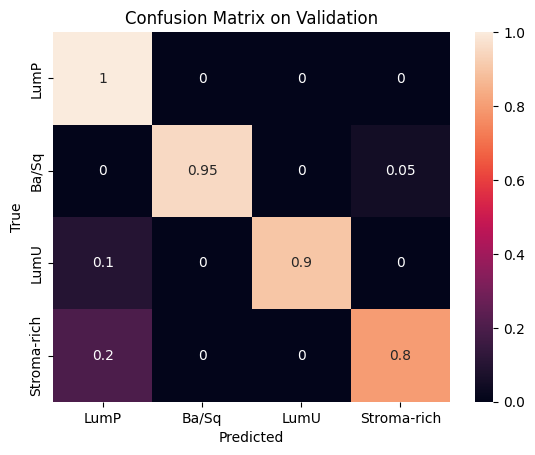

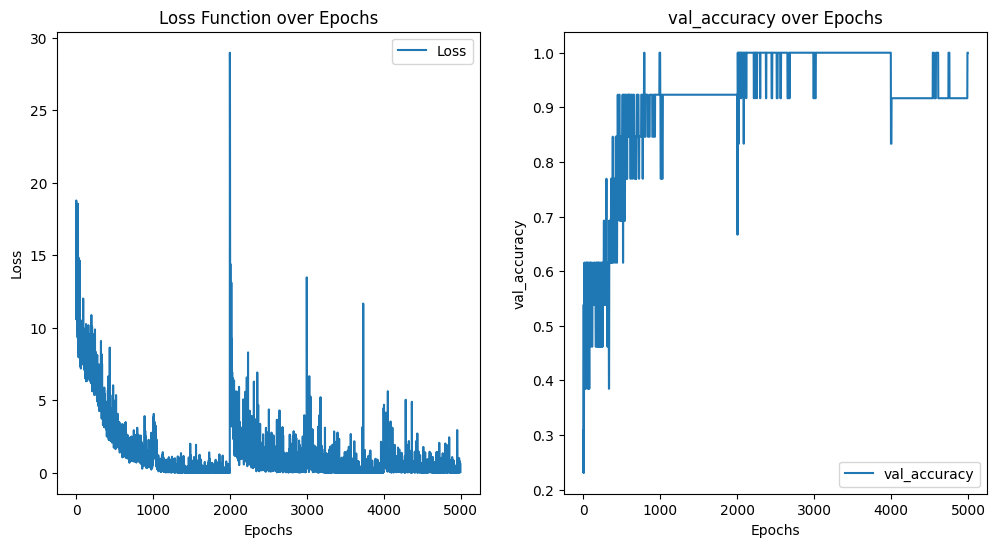

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 1, Fold: 2, Epoch: 050, Loss: 5.0373, Train_acc 0.8542, Val_acc 0.8462
Graph: 1, Fold: 2, Epoch: 100, Loss: 2.8081, Train_acc 0.9167, Val_acc 0.9231
Graph: 1, Fold: 2, Epoch: 150, Loss: 1.9311, Train_acc 0.9375, Val_acc 0.9231
Graph: 1, Fold: 2, Epoch: 200, Loss: 1.7111, Train_acc 0.9375, Val_acc 0.9231
Graph: 1, Fold: 2, Epoch: 250, Loss: 1.9947, Train_acc 0.9583, Val_acc 0.9231
Graph: 1, Fold: 2, Epoch: 300, Loss: 1.6510, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 350, Loss: 1.5335, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 400, Loss: 0.8581, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 450, Loss: 0.9189, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 500, Loss: 2.8341, Train_acc 0.9583, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 550, Loss: 0.3669, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 600, Loss: 0.9000, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 2, Epoch: 650, Loss: 0.5202, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 2, Fold: 2, Epoch: 050, Loss: 0.2357, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 100, Loss: 0.2289, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 150, Loss: 0.7624, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 200, Loss: 0.2628, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 250, Loss: 0.0380, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 300, Loss: 0.2746, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 350, Loss: 0.0250, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 400, Loss: 0.0592, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 450, Loss: 0.5621, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 500, Loss: 0.1318, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 550, Loss: 0.8685, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 600, Loss: 0.0591, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 2, Epoch: 650, Loss: 0.0391, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 3, Fold: 2, Epoch: 050, Loss: 6.9250, Train_acc 0.8750, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 100, Loss: 6.3686, Train_acc 0.9167, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 150, Loss: 6.4370, Train_acc 0.8958, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 200, Loss: 2.9317, Train_acc 0.9792, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 250, Loss: 1.3547, Train_acc 0.9375, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 300, Loss: 4.8340, Train_acc 0.9375, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 350, Loss: 1.7144, Train_acc 0.9583, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 400, Loss: 4.0064, Train_acc 0.9792, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 450, Loss: 2.6774, Train_acc 0.9792, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 500, Loss: 1.7705, Train_acc 0.9792, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 550, Loss: 1.7638, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 600, Loss: 0.9802, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 2, Epoch: 650, Loss: 0.3644, Train_acc 0.9792, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 4, Fold: 2, Epoch: 050, Loss: 0.8806, Train_acc 1.0000, Val_acc 0.8333
Graph: 4, Fold: 2, Epoch: 100, Loss: 0.5870, Train_acc 1.0000, Val_acc 0.9167
Graph: 4, Fold: 2, Epoch: 150, Loss: 0.8062, Train_acc 1.0000, Val_acc 0.8333
Graph: 4, Fold: 2, Epoch: 200, Loss: 0.2868, Train_acc 1.0000, Val_acc 0.8333
Graph: 4, Fold: 2, Epoch: 250, Loss: 0.7572, Train_acc 1.0000, Val_acc 0.8333
Graph: 4, Fold: 2, Epoch: 300, Loss: 0.3984, Train_acc 1.0000, Val_acc 0.9167
Graph: 4, Fold: 2, Epoch: 350, Loss: 0.9329, Train_acc 1.0000, Val_acc 0.9167
Graph: 4, Fold: 2, Epoch: 400, Loss: 0.1782, Train_acc 1.0000, Val_acc 0.9167
Graph: 4, Fold: 2, Epoch: 450, Loss: 0.1197, Train_acc 1.0000, Val_acc 0.8333
Graph: 4, Fold: 2, Epoch: 500, Loss: 0.1334, Train_acc 1.0000, Val_acc 0.9167
Graph: 4, Fold: 2, Epoch: 550, Loss: 0.1746, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 2, Epoch: 600, Loss: 0.2599, Train_acc 1.0000, Val_acc 0.9167
Graph: 4, Fold: 2, Epoch: 650, Loss: 0.3524, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 5, Fold: 2, Epoch: 050, Loss: 3.6867, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 100, Loss: 1.8673, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 150, Loss: 0.8556, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 200, Loss: 2.2883, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 250, Loss: 0.7645, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 300, Loss: 2.1043, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 350, Loss: 0.2958, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 400, Loss: 0.7733, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 450, Loss: 0.5460, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 500, Loss: 2.3318, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 550, Loss: 0.0516, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 600, Loss: 0.2772, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 2, Epoch: 650, Loss: 0.0627, Train_acc 1.0000, V

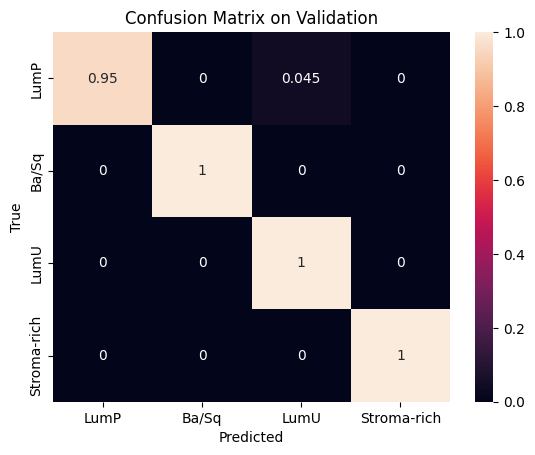

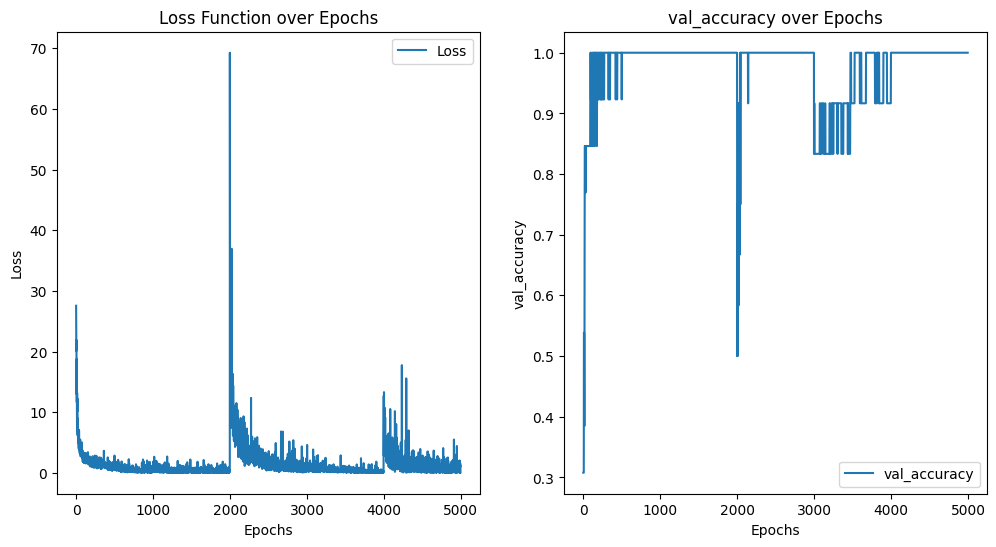

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 1, Fold: 3, Epoch: 050, Loss: 6.4964, Train_acc 0.7917, Val_acc 0.7692
Graph: 1, Fold: 3, Epoch: 100, Loss: 4.9554, Train_acc 0.8958, Val_acc 0.8462
Graph: 1, Fold: 3, Epoch: 150, Loss: 3.6666, Train_acc 0.9583, Val_acc 0.8462
Graph: 1, Fold: 3, Epoch: 200, Loss: 2.5017, Train_acc 0.9583, Val_acc 0.8462
Graph: 1, Fold: 3, Epoch: 250, Loss: 1.9923, Train_acc 0.9583, Val_acc 0.9231
Graph: 1, Fold: 3, Epoch: 300, Loss: 2.1422, Train_acc 0.9583, Val_acc 0.9231
Graph: 1, Fold: 3, Epoch: 350, Loss: 1.6905, Train_acc 0.9792, Val_acc 0.9231
Graph: 1, Fold: 3, Epoch: 400, Loss: 2.1586, Train_acc 0.9792, Val_acc 0.9231
Graph: 1, Fold: 3, Epoch: 450, Loss: 1.8492, Train_acc 0.9792, Val_acc 0.9231
Graph: 1, Fold: 3, Epoch: 500, Loss: 0.7984, Train_acc 0.9792, Val_acc 0.9231
Graph: 1, Fold: 3, Epoch: 550, Loss: 1.5865, Train_acc 0.9792, Val_acc 0.9231
Graph: 1, Fold: 3, Epoch: 600, Loss: 1.7988, Train_acc 0.9792, Val_acc 0.9231
Graph: 1, Fold: 3, Epoch: 650, Loss: 1.7193, Train_acc 0.9792, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 2, Fold: 3, Epoch: 050, Loss: 3.4161, Train_acc 0.8958, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 100, Loss: 2.3697, Train_acc 0.8958, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 150, Loss: 2.4223, Train_acc 0.8958, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 200, Loss: 2.0953, Train_acc 0.9583, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 250, Loss: 0.6979, Train_acc 0.9792, Val_acc 0.9231
Graph: 2, Fold: 3, Epoch: 300, Loss: 0.5618, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 3, Epoch: 350, Loss: 0.7078, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 3, Epoch: 400, Loss: 0.3909, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 3, Epoch: 450, Loss: 0.1196, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 3, Epoch: 500, Loss: 0.7877, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 3, Epoch: 550, Loss: 0.0579, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 3, Epoch: 600, Loss: 0.0940, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 3, Epoch: 650, Loss: 0.1052, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 3, Fold: 3, Epoch: 050, Loss: 0.9902, Train_acc 0.9792, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 100, Loss: 0.4182, Train_acc 0.9792, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 150, Loss: 0.2205, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 200, Loss: 0.4383, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 250, Loss: 0.4209, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 300, Loss: 0.7623, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 350, Loss: 0.0377, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 400, Loss: 0.3010, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 450, Loss: 0.1171, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 500, Loss: 0.1831, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 550, Loss: 0.2025, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 600, Loss: 0.0977, Train_acc 1.0000, Val_acc 1.0000
Graph: 3, Fold: 3, Epoch: 650, Loss: 0.0524, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 4, Fold: 3, Epoch: 050, Loss: 0.3788, Train_acc 1.0000, Val_acc 0.8333
Graph: 4, Fold: 3, Epoch: 100, Loss: 0.9603, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 150, Loss: 0.9792, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 200, Loss: 0.5793, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 250, Loss: 0.3470, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 300, Loss: 0.1325, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 350, Loss: 0.0892, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 400, Loss: 0.2327, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 450, Loss: 0.4835, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 500, Loss: 0.1473, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 550, Loss: 0.0176, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 600, Loss: 0.0792, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 3, Epoch: 650, Loss: 0.0472, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 5, Fold: 3, Epoch: 050, Loss: 0.3294, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 100, Loss: 0.0149, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 150, Loss: 0.1354, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 200, Loss: 0.0568, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 250, Loss: 1.2699, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 300, Loss: 0.1753, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 350, Loss: 0.1224, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 400, Loss: 0.0065, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 450, Loss: 0.0313, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 500, Loss: 0.2516, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 550, Loss: 0.0300, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 600, Loss: 0.0396, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 3, Epoch: 650, Loss: 0.0076, Train_acc 1.0000, V

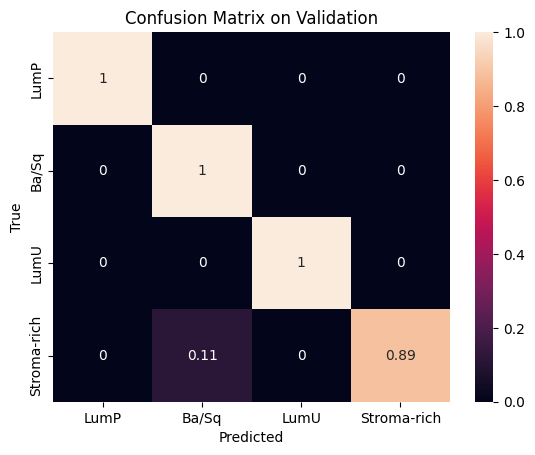

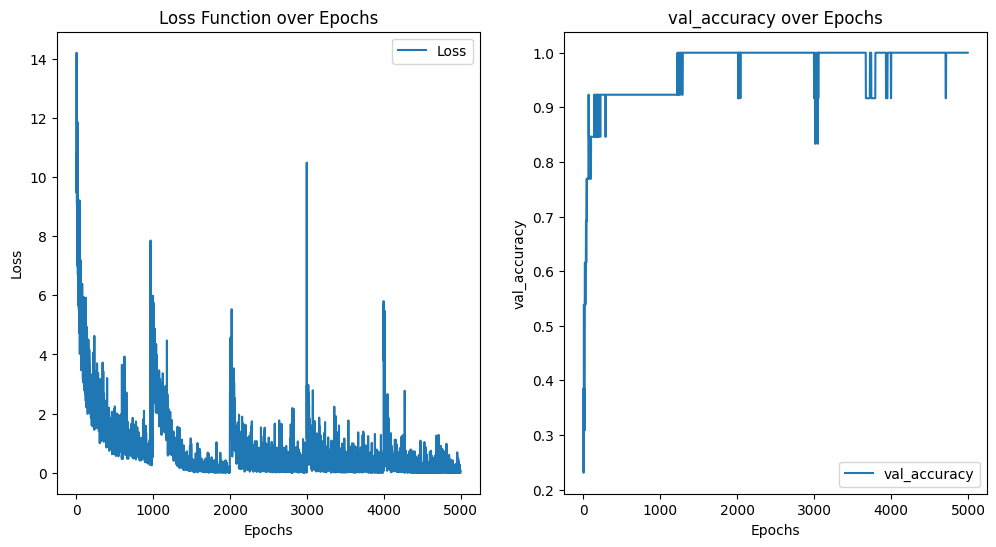

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 1, Fold: 4, Epoch: 050, Loss: 9.1788, Train_acc 0.4583, Val_acc 0.3077
Graph: 1, Fold: 4, Epoch: 100, Loss: 7.7898, Train_acc 0.6458, Val_acc 0.4615
Graph: 1, Fold: 4, Epoch: 150, Loss: 6.9883, Train_acc 0.6250, Val_acc 0.5385
Graph: 1, Fold: 4, Epoch: 200, Loss: 6.0715, Train_acc 0.7500, Val_acc 0.7692
Graph: 1, Fold: 4, Epoch: 250, Loss: 7.6383, Train_acc 0.7917, Val_acc 0.7692
Graph: 1, Fold: 4, Epoch: 300, Loss: 4.8997, Train_acc 0.7917, Val_acc 0.7692
Graph: 1, Fold: 4, Epoch: 350, Loss: 5.4619, Train_acc 0.7708, Val_acc 0.7692
Graph: 1, Fold: 4, Epoch: 400, Loss: 4.4385, Train_acc 0.8125, Val_acc 0.7692
Graph: 1, Fold: 4, Epoch: 450, Loss: 4.1819, Train_acc 0.7708, Val_acc 0.7692
Graph: 1, Fold: 4, Epoch: 500, Loss: 3.1252, Train_acc 0.8542, Val_acc 0.8462
Graph: 1, Fold: 4, Epoch: 550, Loss: 3.0663, Train_acc 0.8750, Val_acc 0.8462
Graph: 1, Fold: 4, Epoch: 600, Loss: 3.0273, Train_acc 0.8542, Val_acc 0.7692
Graph: 1, Fold: 4, Epoch: 650, Loss: 1.9848, Train_acc 0.9167, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 2, Fold: 4, Epoch: 050, Loss: 1.1467, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 4, Epoch: 100, Loss: 0.3387, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 4, Epoch: 150, Loss: 0.1153, Train_acc 1.0000, Val_acc 0.8462
Graph: 2, Fold: 4, Epoch: 200, Loss: 0.3458, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 4, Epoch: 250, Loss: 0.6139, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 4, Epoch: 300, Loss: 0.0206, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 4, Epoch: 350, Loss: 1.0117, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 4, Epoch: 400, Loss: 0.0581, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 4, Epoch: 450, Loss: 0.1583, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 4, Epoch: 500, Loss: 0.0350, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 4, Epoch: 550, Loss: 0.0565, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 4, Epoch: 600, Loss: 0.0453, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 4, Epoch: 650, Loss: 0.1212, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 3, Fold: 4, Epoch: 050, Loss: 0.3907, Train_acc 1.0000, Val_acc 0.8333
Graph: 3, Fold: 4, Epoch: 100, Loss: 0.9110, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 4, Epoch: 150, Loss: 0.2306, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 4, Epoch: 200, Loss: 0.2628, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 4, Epoch: 250, Loss: 0.0127, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 4, Epoch: 300, Loss: 0.0592, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 4, Epoch: 350, Loss: 0.0438, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 4, Epoch: 400, Loss: 0.1848, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 4, Epoch: 450, Loss: 0.0099, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 4, Epoch: 500, Loss: 0.1769, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 4, Epoch: 550, Loss: 0.0124, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 4, Epoch: 600, Loss: 0.0139, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 4, Epoch: 650, Loss: 0.0192, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 4, Fold: 4, Epoch: 050, Loss: 0.4107, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 100, Loss: 0.4754, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 150, Loss: 0.4886, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 200, Loss: 0.5074, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 250, Loss: 0.2349, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 300, Loss: 0.0409, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 350, Loss: 0.0290, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 400, Loss: 0.4192, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 450, Loss: 0.0856, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 500, Loss: 0.2530, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 550, Loss: 0.1638, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 600, Loss: 0.1180, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 4, Epoch: 650, Loss: 0.0333, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 5, Fold: 4, Epoch: 050, Loss: 0.1668, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 100, Loss: 0.5712, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 150, Loss: 1.3364, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 200, Loss: 0.1610, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 250, Loss: 1.1240, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 300, Loss: 0.6167, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 4, Epoch: 350, Loss: 0.1670, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 400, Loss: 0.0141, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 450, Loss: 0.4063, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 500, Loss: 0.2646, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 550, Loss: 0.0415, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 600, Loss: 0.0035, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 4, Epoch: 650, Loss: 0.0227, Train_acc 1.0000, V

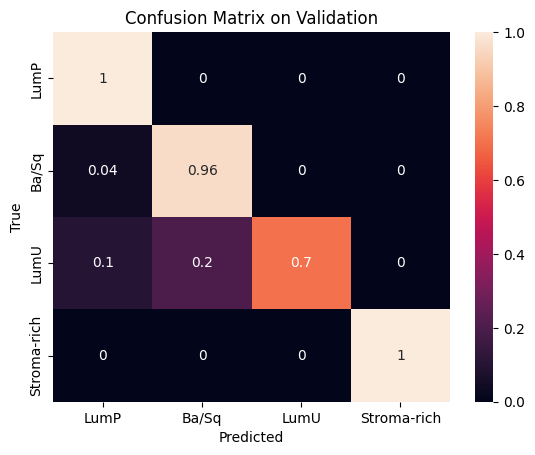

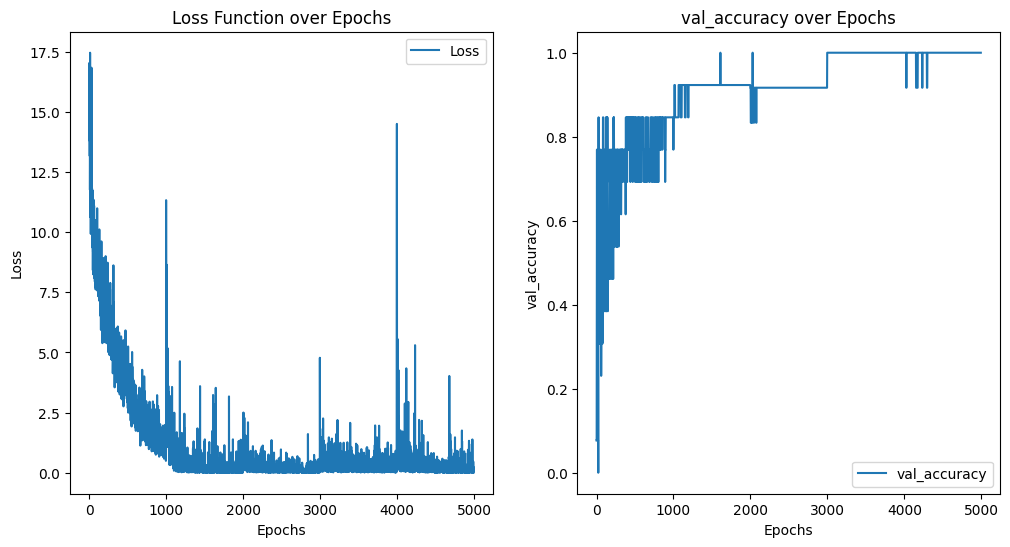

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 1, Fold: 5, Epoch: 050, Loss: 2.7065, Train_acc 0.8958, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 100, Loss: 2.5557, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 150, Loss: 1.0963, Train_acc 0.9583, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 200, Loss: 0.9912, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 250, Loss: 1.0729, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 300, Loss: 0.6972, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 350, Loss: 0.9093, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 400, Loss: 0.8221, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 450, Loss: 0.5013, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 500, Loss: 0.3878, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 550, Loss: 0.6777, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 600, Loss: 0.3881, Train_acc 0.9792, Val_acc 1.0000
Graph: 1, Fold: 5, Epoch: 650, Loss: 0.3505, Train_acc 0.9792, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 2, Fold: 5, Epoch: 050, Loss: 1.9457, Train_acc 0.9167, Val_acc 0.9231
Graph: 2, Fold: 5, Epoch: 100, Loss: 2.5758, Train_acc 0.9583, Val_acc 0.9231
Graph: 2, Fold: 5, Epoch: 150, Loss: 1.3079, Train_acc 0.9583, Val_acc 1.0000
Graph: 2, Fold: 5, Epoch: 200, Loss: 0.8738, Train_acc 0.9583, Val_acc 0.9231
Graph: 2, Fold: 5, Epoch: 250, Loss: 1.2104, Train_acc 0.9792, Val_acc 1.0000
Graph: 2, Fold: 5, Epoch: 300, Loss: 0.6368, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 5, Epoch: 350, Loss: 0.7503, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 5, Epoch: 400, Loss: 1.4673, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 5, Epoch: 450, Loss: 0.8618, Train_acc 1.0000, Val_acc 0.9231
Graph: 2, Fold: 5, Epoch: 500, Loss: 0.5294, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 5, Epoch: 550, Loss: 0.3905, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 5, Epoch: 600, Loss: 0.5283, Train_acc 1.0000, Val_acc 1.0000
Graph: 2, Fold: 5, Epoch: 650, Loss: 0.2046, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 3, Fold: 5, Epoch: 050, Loss: 1.5587, Train_acc 0.9792, Val_acc 0.8333
Graph: 3, Fold: 5, Epoch: 100, Loss: 0.2782, Train_acc 0.9792, Val_acc 0.9167
Graph: 3, Fold: 5, Epoch: 150, Loss: 1.8305, Train_acc 0.9792, Val_acc 0.8333
Graph: 3, Fold: 5, Epoch: 200, Loss: 0.8256, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 5, Epoch: 250, Loss: 0.4404, Train_acc 0.9792, Val_acc 0.9167
Graph: 3, Fold: 5, Epoch: 300, Loss: 0.8696, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 5, Epoch: 350, Loss: 0.1741, Train_acc 1.0000, Val_acc 0.8333
Graph: 3, Fold: 5, Epoch: 400, Loss: 0.1508, Train_acc 1.0000, Val_acc 0.8333
Graph: 3, Fold: 5, Epoch: 450, Loss: 0.1015, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 5, Epoch: 500, Loss: 0.8462, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 5, Epoch: 550, Loss: 0.1047, Train_acc 1.0000, Val_acc 0.8333
Graph: 3, Fold: 5, Epoch: 600, Loss: 0.1323, Train_acc 1.0000, Val_acc 0.9167
Graph: 3, Fold: 5, Epoch: 650, Loss: 0.5511, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 4, Fold: 5, Epoch: 050, Loss: 0.3999, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 100, Loss: 0.0823, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 150, Loss: 0.1441, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 200, Loss: 0.0401, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 250, Loss: 0.0167, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 300, Loss: 0.0336, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 350, Loss: 0.0064, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 400, Loss: 0.0137, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 450, Loss: 0.0890, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 500, Loss: 0.0121, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 550, Loss: 0.0243, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 600, Loss: 0.0033, Train_acc 1.0000, Val_acc 1.0000
Graph: 4, Fold: 5, Epoch: 650, Loss: 0.0079, Train_acc 1.0000, V

/tmp/ipykernel_82713/274800562.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


Graph: 5, Fold: 5, Epoch: 050, Loss: 1.6473, Train_acc 0.9792, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 100, Loss: 0.9637, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 5, Epoch: 150, Loss: 0.4802, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 200, Loss: 0.3420, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 5, Epoch: 250, Loss: 0.0940, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 300, Loss: 0.2235, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 350, Loss: 0.3927, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 5, Epoch: 400, Loss: 0.2824, Train_acc 1.0000, Val_acc 1.0000
Graph: 5, Fold: 5, Epoch: 450, Loss: 0.0587, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 5, Epoch: 500, Loss: 0.0107, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 5, Epoch: 550, Loss: 0.1342, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 5, Epoch: 600, Loss: 0.0479, Train_acc 1.0000, Val_acc 0.9167
Graph: 5, Fold: 5, Epoch: 650, Loss: 0.1821, Train_acc 1.0000, V

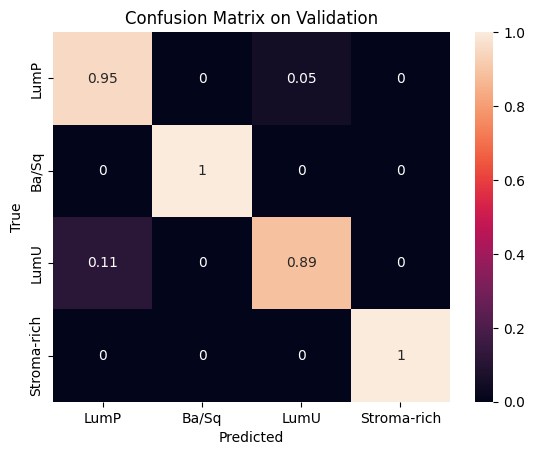

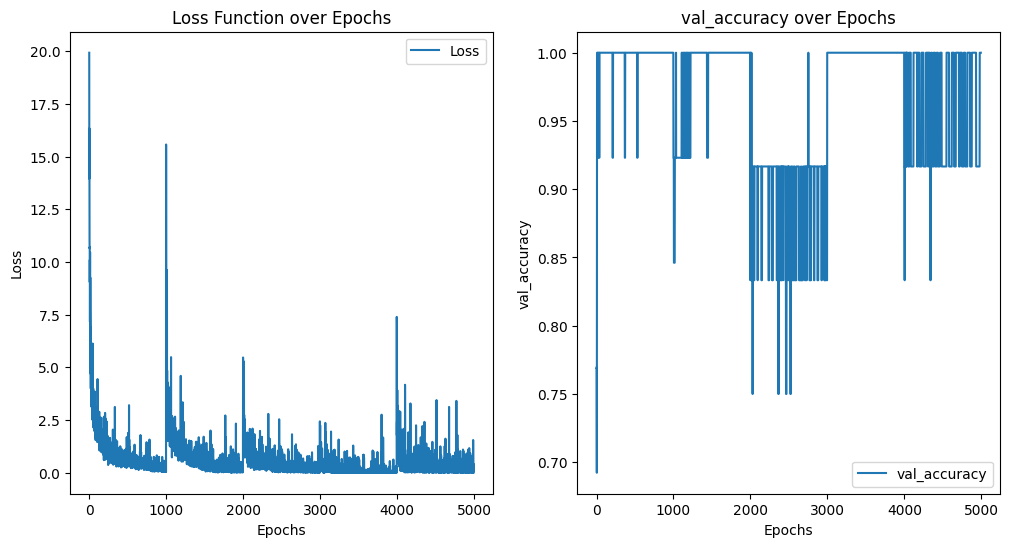

Mean Validation Accuracy: 1.0000, Std Validation Accuracy: 0.0000


In [15]:
# Training phase
similarity_threshold = 0.5

train_val_indices, test_indices = train_test_split(
    range(len(node_features)), 
    test_size=0.2, 
    random_state=1234
)

train_val_data = get_data(train_val_indices, similarity_threshold,num_classes=4)
test_data = get_data(test_indices, similarity_threshold, num_classes=4)

best_model, mean_val_acc = cross_validation_induction(train_val_data, k_folds=5, hidden_channels=20, heads=8, num_epochs=1000)

Test accuracy: 0.8684


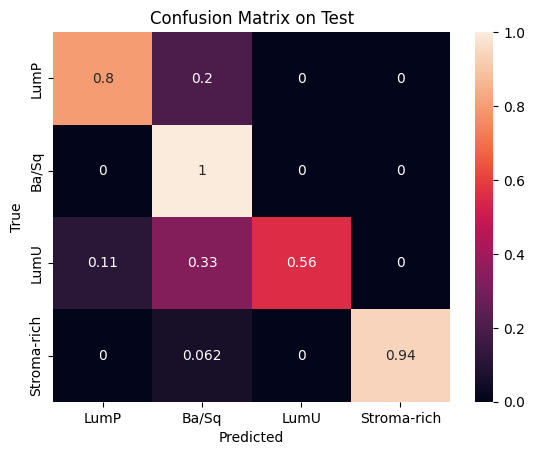

In [16]:
# Testing phase

test_mask = torch.ones(test_data.num_nodes, dtype=torch.bool)
test_acc, y_pred = test(best_model, test_data, test_mask)
y_true = test_data.y[test_mask]

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())
print(f'Test accuracy: {test_acc:.4f}')
classes = ('LumP', 'Ba/Sq', 'LumU', 'Stroma-rich')
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(conf_matrix_normalized, index=classes, columns=classes)  
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test')
plt.show()